In [1]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [16]:
# Number of Qubits 
N=6
# Number of excitations
k=3
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=2
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

# Deciding between grid and 1d chain topology
my_topology = my_chain

 Qubit indices in chain: 
 [0 1 2 3 4 5]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5)]

 Initialization strategy is: 
 [0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5]


In [17]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")
print("Check that qubo min cost is same as portfolio min cost:")
print(qubo_min_cost, portfolio_subspace_min_cost)
print("Check that qubo max cost is at least portfolio max cost:")
print(qubo_max_cost, portfolio_subspace_max_cost)

# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 with_z_phase=False,
                 debug_verbose=True)

Min. cost portfolio (constrained subspace): 4.792675492871994
Optimal portfolio state (constrained subspace) is: |010110>
Min. cost QUBO: 4.792675492871986
Min. cost QUBO state is: |010110>
Check that qubo min cost is same as portfolio min cost:
4.792675492871986 4.792675492871994
Check that qubo max cost is at least portfolio max cost:
75.16958453646555 11.185011781432737


In [18]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_most_probables = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    CP_z_phase_most_probables.append(list(_dict_.keys())[np.argmax(list(_dict_.values()))])
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")    

CP+Z-PHASE: 26


In [ ]:
    
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method='COBYLA',
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=CP_z_phase_callback_function)
"""except Exception as e:
    if str(e) == "Termination criteria met":
        print("Optimization stopped due to custom termination criteria.")"""

-- Layer: 0 --
adding theta: 1
adding state 1
adding theta: 2
adding state 2
adding theta: 3
adding state 3
adding theta: 4
adding state 4
adding theta: 5
adding state 5
adding theta: 6
adding state 6
adding theta: 7
adding state 7
adding theta: 8
adding state 8
adding theta: 9
adding state 9
-- Layer: 1 --
adding theta: 10
adding state 10
adding theta: 11
adding state 11
adding theta: 12
adding state 12
adding theta: 13
adding state 13
adding theta: 14
adding state 14
adding theta: 15
adding state 15
adding theta: 16
adding state 16
adding theta: 17
adding state 17
adding theta: 18
adding state 18
-- Layer: 0 --
adding theta: 1
adding state 1
adding theta: 2
adding state 2
adding theta: 3
adding state 3
adding theta: 4
adding state 4
adding theta: 5
adding state 5
adding theta: 6
adding state 6
adding theta: 7
adding state 7
adding theta: 8
adding state 8
adding theta: 9
adding state 9
-- Layer: 1 --
adding theta: 10
adding state 10
adding theta: 11
adding state 11
adding theta: 12
ad

Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
  File "/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 267, in fun
    self._update_fun()
  File "/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
    self._update_fun_impl()
  File "/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
    self.f = fun_wrapped(self.x)
  File "/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 

adding theta: 7
adding state 7
adding theta: 8
adding state 8
adding theta: 9
adding state 9
-- Layer: 1 --
adding theta: 10
adding state 10
adding theta: 11
adding state 11
adding theta: 12
adding state 12
adding theta: 13
adding state 13
adding theta: 14
adding state 14
adding theta: 15
adding state 15
adding theta: 16
adding state 16
adding theta: 17
adding state 17
adding theta: 18
adding state 18
-- Layer: 0 --
adding theta: 1
adding state 1
adding theta: 2
adding state 2
adding theta: 3
adding state 3
adding theta: 4
adding state 4
adding theta: 5
adding state 5
adding theta: 6
adding state 6
adding theta: 7
adding state 7
adding theta: 8
adding state 8
adding theta: 9
adding state 9
-- Layer: 1 --
adding theta: 10
adding state 10
adding theta: 11
adding state 11
adding theta: 12
adding state 12
adding theta: 13
adding state 13
adding theta: 14
adding state 14


In [6]:
CP_z_phase_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.3963201923353536
       x: [-6.597e-03  3.927e+00 ...  3.175e-01  7.938e-01]
    nfev: 186
   maxcv: 0.0

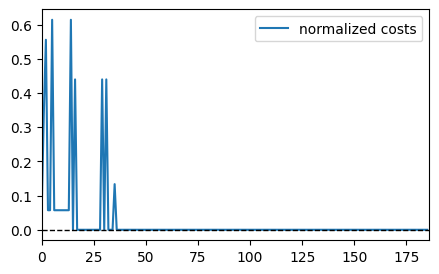

In [7]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

In [8]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Operator
from qiskit.quantum_info.operators import Pauli
from qiskit.opflow import X, Y, I



In [9]:
theta_opt = CP_z_phase_res.x
print(theta_opt)

[-0.00659713  3.92699167  1.90228752  1.57255319 -0.78541994  1.56670016
 -0.78971888  6.24946582  5.51395911 -1.45860705  3.56988191  0.31748515
  0.7938405 ]


In [10]:
N

6

In [11]:

# Generating instances of ansatz'
CP_test_ansatz= CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=True,
                 with_gradient=True,
                 with_z_phase=False,
                 debug_verbose=True)

In [12]:
# population things
_ = CP_test_ansatz.get_cost(angles=theta_opt)

-- Layer: 0 --
adding theta: 1
adding state 1
adding theta: 2
adding state 2
adding theta: 3
adding state 3
adding theta: 4
adding state 4
adding theta: 5
adding state 5
adding theta: 6
adding state 6
adding theta: 7
adding state 7
adding theta: 8
adding state 8
adding theta: 9
adding state 9


In [14]:
len(theta_opt),len(CP_test_ansatz.mid_circuit_states), len(CP_test_ansatz.mid_circuit_indices)

(13, 9, 9)

In [111]:
np.linalg.norm(CP_test_ansatz.get_gradient(angles=theta_opt))

0.012126476474119973